In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
def statistics(data):
    print 'Events:', len(numpy.unique(data.event)), 'vrt:', len(data)

## Reading initial data

In [4]:
data_nan = pandas.read_csv('../../datasets/Tagging/Vertices.csv', sep='\t')
data = data_nan.dropna()
len(data_nan), len(data)

(610050, 610050)

In [5]:
data.head()

,run,event,No,mult,nnkrec,Bmass,ptB,vflag,ptmean,ipsmean,vcharge,svm,svp,BDphiDir,svtau,docamax,signB,signVtx,N_sig_sw,v_cut
0,115839,490856995,0,19,3,5.27051,0.682494,5,0.612396,2.82952,0.369395,8.090450,234.8170,-1.014500,0.848175,0.011098,-1,-1,1.034010,0
1,115839,822264706,0,10,2,5.28157,8.309650,2,0.438413,4.65750,0.426932,0.483020,20.8185,0.390429,4.783480,0.000000,-1,1,1.091840,0
2,115839,831865829,0,50,6,5.21344,1.150550,2,0.560779,5.98035,1.133610,1.332900,33.1151,-0.039351,0.837979,0.000000,-1,-1,-0.442372,0
3,115839,835954815,0,21,2,5.27418,5.809860,2,0.574965,15.80120,0.207937,0.508337,32.2970,0.013839,9.961430,0.000000,1,1,1.071050,0
4,115839,68238381,0,16,4,5.23794,2.200840,5,0.818976,4.17709,0.402122,6.816220,88.1742,-1.098810,1.092720,0.009995,-1,1,-0.263734,0


In [6]:
statistics(data)

Events: 609984 vrt: 610050


# Find vrt 

`label` = `signB` * `signVtx`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Choose B-events

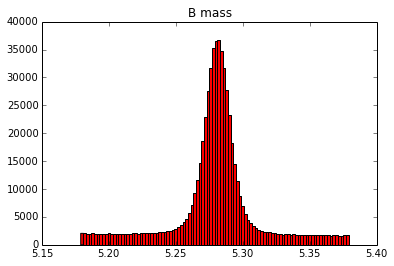

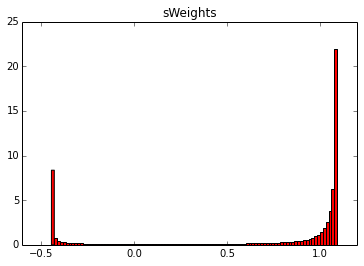

In [7]:
hist(data.Bmass.values, bins=100)
title('B mass')
show()
hist(data.N_sig_sw.values, bins=100, normed=True)
title('sWeights')
pass

In [8]:
sweight_threshold = 1.
data = data[data.N_sig_sw > sweight_threshold]
statistics(data)

Events: 353423 vrt: 353443


In [11]:
train_events_id = pandas.read_csv('events_train.csv')['train_id']
test_events_id = pandas.read_csv('events_test.csv')['test_id']
set(numpy.unique(data.event)).issubset(set(numpy.concatenate([train_events_id, test_events_id]) ))

In [14]:
data = data.ix[numpy.in1d(data.event.values, train_events_id), :]

In [16]:
statistics(data)

Events: 176769 vrt: 176781


## Define features

In [15]:
features = list(set(data.columns) - {'run', 'event', 'No', 'signB', 'signVtx', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi'})
features

['vflag',
 'svm',
 'BDphiDir',
 'vcharge',
 'svp',
 'v_cut',
 'docamax',
 'ptB',
 'svtau',
 'ptmean',
 'nnkrec',
 'ipsmean']

### define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [17]:
product_sign = (data.signB.values * data.signVtx.values > 0) * 1

### 2-folding training

In [18]:
import cPickle
with open('vtx_forest.pkl', 'r') as f:
    est_choose_RT = cPickle.load(f)

In [24]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=20, n_jobs=8)
est_choose_RT = FoldingClassifier(base, features=features, random_state=13)
est_choose_RT.fit(data, product_sign, data.N_sig_sw)

FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=13)

In [25]:
import cPickle
with open('vtx_forest.pkl', 'w') as f:
    cPickle.dump(est_choose_RT, f)

----

### AUC

In [26]:
probs_RT = est_choose_RT.predict_proba(data)
roc_auc_score(product_sign, probs_RT[:, 1], sample_weight=data.N_sig_sw.values)

KFold prediction using folds column


0.53730752705361895

### ROC

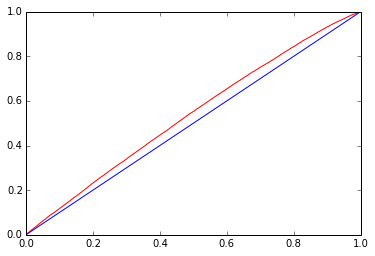

In [27]:
fpr, tpr, _ = roc_curve(product_sign, probs_RT[:, 1], sample_weight=data.N_sig_sw.values)
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [28]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(est_choose_RT.features)[numpy.argsort(-imp)]})

,feature,importance
0,vcharge,1.000000
1,ptmean,0.548558
2,svm,0.526753
3,ipsmean,0.448831
4,svp,0.429169
5,svtau,0.421517
6,BDphiDir,0.406156
7,ptB,0.382805
8,docamax,0.271211
9,vflag,0.101556


## Distributions for output

In [29]:
from rep.utils import Flattener

In [30]:
def run_flat_probs(probs, labels, weights, label=1):
    figsize(8, 6)
    flat = Flattener(probs[:, 1][labels == label], weights[labels == label])
    flat_probs = flat(probs[:, 1])
    hist(flat_probs[labels == 1], bins=100, normed=True, histtype='step', 
         weights=weights[labels == 1], label='same sign')
    hist(flat_probs[labels == 0], bins=100, normed=True, histtype='step', 
         weights=weights[labels == 0], label='opposite sign')
    xlabel('predictions')
    legend(loc='upper center')
    show()
    return flat_probs

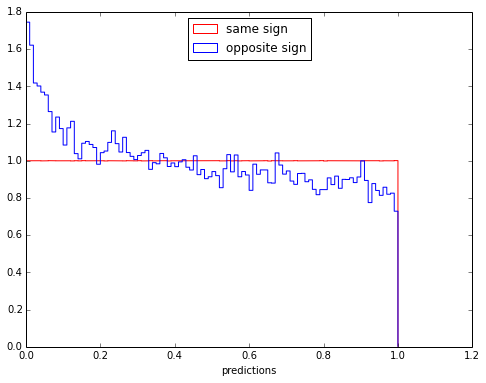

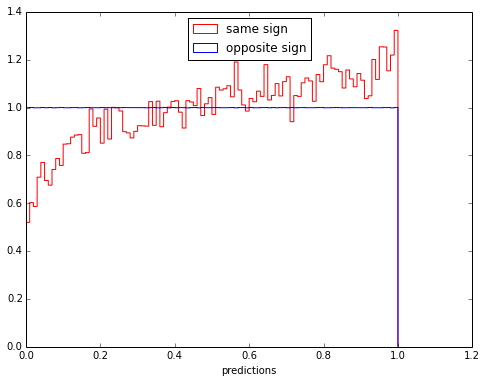

In [114]:
flat_ss_probs = run_flat_probs(probs_RT, product_sign, data.N_sig_sw.values, label=1)
flat_os_probs = run_flat_probs(probs_RT, product_sign, data.N_sig_sw.values, label=0)

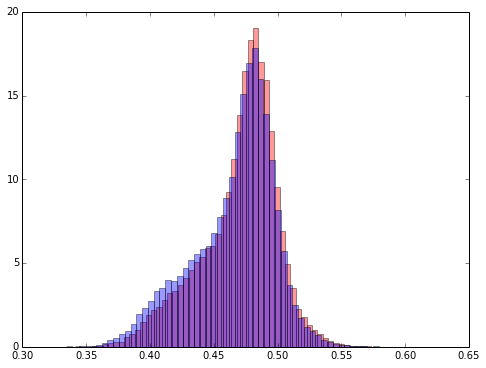

In [115]:
hist(probs_RT[product_sign == 1][:, 1], bins=60, normed=True, alpha=0.4)
hist(probs_RT[product_sign == 0][:, 1], bins=60, normed=True, alpha=0.4)
pass

## Select good svr

In [89]:
from rep_ef.estimators import MatrixNetSkyGridClassifier

In [117]:
from rep.utils import train_test_split_group
data_train, data_test_gl, flat_ss_probs, _ , flat_os_probs, _, labels_train, labels_test_gl = \
                                                                train_test_split_group(data['event'],
                                                                                    data, flat_ss_probs,
                                                                                    flat_os_probs, product_sign,
                                                                                    random_state=11, train_size=0.5)

In [118]:
data_selected_forest = data_train[((flat_ss_probs < 0.1) & (labels_train == 0)) | 
                                  ((flat_os_probs > 0.8) & (labels_train == 1))]

In [119]:
statistics(data_selected_forest)

Events: 16053 vrt: 16053


--------------

In [23]:
with open('vtx_mn_selected.pkl', 'r') as f:
    mn_folding = cPickle.load(f)

In [120]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)
mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                               features=features)
labels_sel = (data_selected_forest['signB'].values * data_selected_forest['signVtx'].values > 0) * 1
mn_folding.fit(data_selected_forest, labels_sel, data_selected_forest.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=3000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=11)

In [121]:
with open('vtx_mn_selected.pkl', 'w') as f:
    cPickle.dump(mn_folding, f)

---------

In [ ]:
with open('vtx_mn.pkl', 'r') as f:
    mn_folding_all = cPickle.load(f)

In [39]:
mn_folding_all = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                   features=features)
mn_folding_all.fit(data_train, labels_train, data_train.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=3000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=11)

In [40]:
with open('vtx_mn.pkl', 'w') as f:
    cPickle.dump(mn_folding_all, f)

--------

## Isotonic calibration to probabity p(vrt same sign|B)

In [42]:
from sklearn.isotonic import IsotonicRegression

In [103]:
iso_calibs = []
aucs = []
D2 = []
est = mn_folding
for k in range(100):
    data_calib, data_test, labels_calib, labels_test = train_test_split_group(data_test_gl['event'],
                                                                              data_test_gl, 
                                                                              labels_test_gl, 
                                                                              train_size=0.5)
    probs_sign_sel = est.predict_proba(data_calib)[:, 1]
    calib_probs_sel = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
    calib_probs_sel.fit(probs_sign_sel, labels_calib)
    iso_calibs.append(calib_probs_sel)
    probs_sign_test = mn_folding.predict_proba(data_test)[:, 1]
    w_test = data_test.N_sig_sw.values
    aucs.append(roc_auc_score(labels_test, probs_sign_test, sample_weight=w_test))
    probs_sign_test_calib = calib_probs_sel.transform(probs_sign_test)
    alpha = (1 - 2 * (1 - probs_sign_test_calib))**2
    D2.append(sum(alpha * w_test) / sum(w_test))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds

In [104]:
print numpy.mean(aucs), numpy.var(aucs)

0.544597252323 3.5559580865e-06


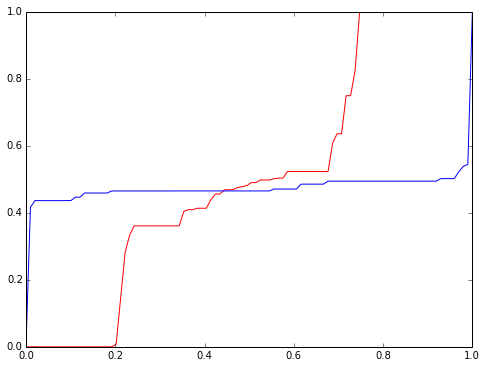

In [105]:
x = numpy.linspace(0, 1, 100)
plot(x, calib_probs.transform(x))
plot(x, calib_probs_sel.transform(x))

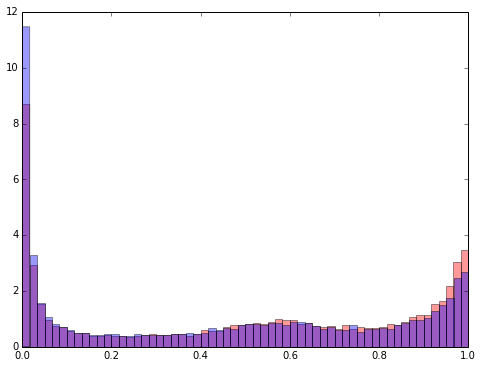

In [106]:
hist(probs_sign_test[labels_test == 1], bins=60, alpha=0.4, normed=True)
hist(probs_sign_test[labels_test == 0], bins=60, alpha=0.4, normed=True)
pass

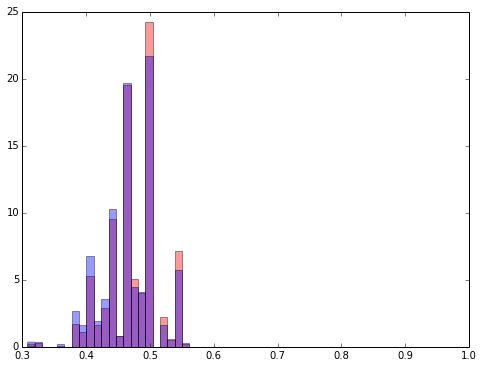

In [107]:
hist(probs_sign_test_calib[labels_test == 1], bins=60, normed=True, alpha=0.4)
hist(probs_sign_test_calib[labels_test == 0], bins=60, normed=True, alpha=0.4)
pass

In [135]:
sum(labels_test == 1) * 1. / sum(labels_test == 0 )

0.87505303351718289

In [111]:
numpy.mean(D2), numpy.var(D2)

(0.011633884674103636, 5.0381047745462486e-07)

## Compute D2

In [108]:
numpy.mean(D2), numpy.var(D2)

(0.76783638849084002, 5.0381047745462486e-07)

In [109]:
with open('vtx_iso.pkl', 'w') as f:
    cPickle.dump(iso_calibs, f)

---------------------